In [1]:
# Training NN with Elegy then do HMC with Oryx on Mana
# Author: Peter Oct 28 2021
# Requirements: 
#!module load system/CUDA/11.0.2 
#!pip install --upgrade jax jaxlib==0.1.68+cuda110 -f https://storage.googleapis.com/jax-releases/jax_releases.html 
#!pip install tensorflow-io oryx elegy

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import jax
import jax.numpy as jnp
from jax import random, vmap, jit, grad
assert jax.default_backend() == 'gpu'
import importlib
import gcr_utils
importlib.reload(gcr_utils)
#from gcr_utils import load_preprocessed_data_ams, define_target_log_prob, define_nn, denormalize_samples, remove_consecutive_duplicates
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
import elegy # pip install elegy. 
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
#import oryx  # pip install oryx

# Hyperparameters
num_results = 1000 # 10k takes 11min
num_burnin_steps = 0#1000 #500
num_adaptation_steps = np.floor(.8*num_burnin_steps) #Somewhat smaller than number of burnin
target_accept_prob = 0.3
step_size = 1e-6 # 1e-5 has 0.95 acc rate and moves. 1e-4 0.0 acc.
num_leapfrog_steps = 100
max_tree_depth = 10 # Default=10. Smaller results in shorter steps. Larger takes memory.
model_path = 'model_2_256_selu_l21e-6' #'model_2_256_selu_l21e-6_do' # 'model_2_256_selu_l21e-6' #'model_2_256_selu'

seed = 6
key = random.PRNGKey(seed)

# Load observation data and define logprob.
target_log_prob = gcr_utils.define_log_prob(model_path)

@jit
def run_chain(key, state):
    # Example from https://colab.research.google.com/github/tensorflow/probability/blob/master/spinoffs/oryx/examples/notebooks/probabilistic_programming.ipynb#scrollTo=nmjmxzGhN855
    # kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    #             #tfp.mcmc.HamiltonianMonteCarlo(flat_log_prob, step_size=step_size, num_leapfrog_steps=num_leapfrog_steps),
    #             tfp.mcmc.HamiltonianMonteCarlo(target_log_prob, step_size=step_size, num_leapfrog_steps=num_leapfrog_steps),
    #             num_adaptation_steps=num_adaptation_steps,
    #             target_accept_prob=target_accept_prob)
    # def trace_fn(_, pkr):
    #     return [pkr.inner_results.log_accept_ratio,
    #             pkr.inner_results.accepted_results.target_log_prob,
    #             pkr.inner_results.accepted_results.step_size]
    
    #kernel = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob, step_size=step_size, num_leapfrog_steps=num_leapfrog_steps)
    max_energy_diff = 1000 #1e32 #1e21 # Default 1000.0. Divergent samples are those that exceed this.
    kernel = tfp.mcmc.NoUTurnSampler(target_log_prob, step_size=step_size, max_tree_depth=max_tree_depth, 
                                     max_energy_diff=max_energy_diff, unrolled_leapfrog_steps=1,)
    def trace_fn(_, pkr):
        return [pkr.log_accept_ratio,
                pkr.target_log_prob,
                pkr.step_size]
    
    kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
        kernel,
        num_adaptation_steps=int(num_burnin_steps * 0.8),
        step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(step_size=new_step_size),
        step_size_getter_fn=lambda pkr: pkr.step_size,
        log_accept_prob_getter_fn=lambda pkr: pkr.log_accept_ratio,
    )
    def trace_fn(_, pkr):
        return [pkr.inner_results.log_accept_ratio,
                pkr.inner_results.target_log_prob,
                pkr.inner_results.step_size]
    
    samples, pkr = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        kernel=kernel,
        trace_fn=trace_fn,
        current_state=state,
        seed=key)
    
    return samples, pkr

start_time = time.time()
np.random.seed(seed)
state = np.random.random((5,)) #jnp.random.random((5,), dtype='float32') # used for 29091984
#state = 0.50 * jnp.ones((5,), dtype='float32') # Not sure how to do multiple chains with this likelihood.
#state = jnp.array(gcr_utils.minmax_scale_input(np.array([90, .5, 1.7, 1.4, 1.1 ]))) # This is ~MLE
unnormalized_samples, pkr = run_chain(key, state)
print('Finished in %d minutes.' % int((time.time() - start_time)//60))

# De-normalize samples and remove duplicates.
unnormalized_samples = unnormalized_samples.to_py()
all_samples = gcr_utils.deminmax_scale_input(unnormalized_samples)
samples, pkr_select = gcr_utils.remove_consecutive_duplicates(all_samples, pkr, atol=0.0)
all_log_accept_ratio, all_log_probs, all_step_sizes = pkr
log_accept_ratio, log_probs, step_sizes  = pkr_select
#samples, (log_accept_ratio, log_probs, step_sizes) = gcr_utils.remove_consecutive_duplicates(all_samples, (log_accept_ratio, log_probs, step_sizes))
print(f'Acceptance rate: {len(samples)/len(all_samples)}. Decrease step_size to increase rate.')

print(f'Samples minmaxed: {unnormalized_samples}')
print(f'Samples: {samples}')
print(f'Step sizes: {step_sizes}')
print(f'log_probs: {log_probs}')
unnormalized_samples[0,:] == unnormalized_samples[-1,:]

Finished in 14 minutes.
Acceptance rate: 0.999. Decrease step_size to increase rate.
Samples minmaxed: [[0.20064193 0.1661712  0.7138189  0.66775787 0.42895466]
 [0.19492477 0.16809502 0.7120894  0.6681997  0.42232177]
 [0.19863874 0.17635825 0.7074492  0.6740914  0.41118068]
 ...
 [0.26210642 0.4308038  0.48540458 0.76308644 0.35510293]
 [0.26104796 0.42551032 0.488421   0.74389553 0.35360676]
 [0.25601032 0.4266764  0.49547753 0.7501748  0.35387936]]
Samples: [[ 88.98495436   0.50257104   1.69538778   1.40275949   1.08687571]
 [ 89.72774744   0.51744485   1.68564332   1.41336452   1.06347942]
 [ 90.69110155   0.51531717   1.67899079   1.41780411   1.07736087]
 ...
 [102.42128372   0.97544685   1.21934962   1.57355559   0.94571615]
 [102.20959187   0.96591857   1.22568409   1.53901196   0.9425742 ]
 [101.20206475   0.96801751   1.24050281   1.55031468   0.94314666]]
Step sizes: [1.5751924e-05 1.5751924e-05 1.5751924e-05 1.5751924e-05 1.5751924e-05
 1.5751924e-05 1.5751924e-05 1.575192

array([False, False, False, False, False])

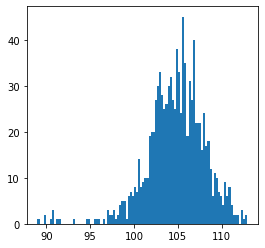

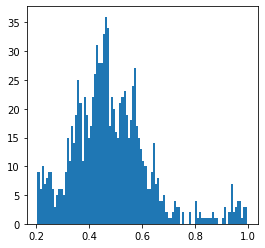

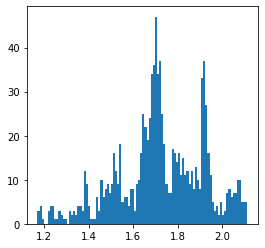

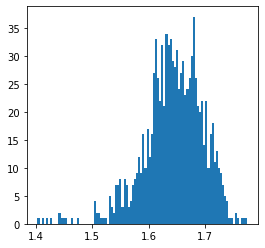

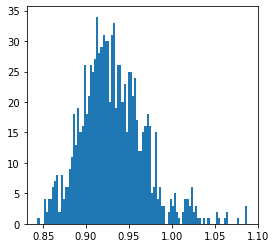

In [4]:
for i in range(5):
    plt.figure(i, figsize=(24,4))
    plt.subplot(1,5, i+1)
    plt.hist(samples[:,i], bins=100)

# Debug: check likelihood function

In [26]:
nn_predict = gcr_utils.define_nn_pred(model_path, normalize_input_flag=True, denormalize_output_flag=True, rebin_output_flag=False)
x = np.array([69.19, 5.17, 90, .5, 1.7, 1.4, 1.1 ])
yhat = nn_predict(x)
logp = gcr_utils.calc_loglikelihood(yhat)
print(logp)
assert np.isclose(logp, all_log_probs[0])

-825227.94


# Debug:  View NN predictions vs. Observed.

In [27]:
# Sanity check: View NN predictions vs. Observed.
target_log_prob = gcr_utils.define_log_prob(model_path)
#nn_pred = gcr_utils.define_nn_pred(model_path, normalize_input_flag=False)
MIN = np.zeros(5)
MAX = np.ones(5)
N = 3
plt.figure(1, figsize=(20,5))
#for i,x in enumerate(np.linspace(MIN, MAX, N)):
for i,x in enumerate(unnormalized_samples[:5]):
    plt.subplot(1,N,i+1)
    #yhat = nn_pred(x)
    logp = target_log_prob(x)
    plt.plot(yhat,label=str(x) + f' {logp}')
plt.legend()    

TypeError: Incompatible shapes for dot: got (5,) and (7, 256).

<Figure size 1440x360 with 0 Axes>

# DEBUG: Plot NLL 

In [ ]:
# Load observation data and define logprob.
target_log_prob = gcr_utils.define_log_prob(model_path)

PARAMETER_NAMES = ['cpa', 'pwr1par', 'pwr2par', 'pwr1perr', 'pwr2perr']
MIN = gcr_utils.minmax_scale_input(np.array([90, .5, 1.7, 1.4, 1.1 ]))
#MIN = np.zeros(5)
MAX = np.ones(5) 

# Plot logprob
for j, START in enumerate(np.linspace(MIN, MAX, 3)):
    plt.figure(j, figsize=(20, 5))
    for i in range(5):
        p1 = START.copy()
        p1[i] = MIN[i] - .01
        p2 = START.copy()
        p2[i] = MAX[i] + .01
        x = np.linspace(p1, p2, 1000)
        y = jax.vmap(target_log_prob)(x)
        plt.subplot(1,5,i+1)
        plt.plot(y)
        plt.xlabel(PARAMETER_NAMES[i])
print(p1, p2) # Debugging    

# DEBUG: Plot gradients

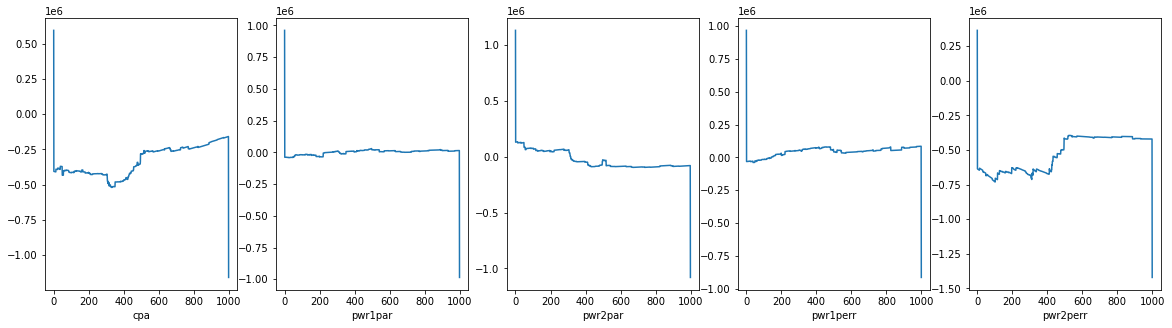

In [29]:
# Load observation data and define logprob.
#xloc, iloc, observed, uncertainty, alpha, cmf = gcr_utils.load_preprocessed_data_ams()
#model_path = 'model_2_256_selu_l21e-6' #'model_2_256_tanh' # 'model'

PARAMETER_NAMES = ['cpa', 'pwr1par', 'pwr2par', 'pwr1perr', 'pwr2perr']
MIN = np.zeros(5)
MAX = np.ones(5)
START =  MIN_VALS #MAX_VALS - MIN_VALS #MAX_VALS #MAX_VALS - MIN_VALS

# Plot logprob
#for j, state in enumerate(np.linspace(MIN_VALS, MAX_VALS, 3)):
state = MIN
plt.figure(j, figsize=(20, 5))
p1 = MIN.copy() - .001
p2 = MAX.copy() + .001
x = np.linspace(p1, p2, 1000)
dydx = jax.vmap(jax.grad(target_log_prob))(x).to_py()
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.plot(dydx[:, i])
    plt.xlabel(PARAMETER_NAMES[i])    

# Debug: Survey grid

In [2]:
n = 10
d = 5
s = 1./n
X = np.mgrid[0:1:s, 0:1:s, 0:1:s, 0:1:s, 0:1:s]
print(X.shape)
# Create vectorized version of farget_log_prob
vf = target_log_prob
for i in range(d):
    vf = jax.vmap(vf, in_axes=1)
logps = vf(X).to_py() # compute all logprob in parallel
print(logps.shape)


(5, 10, 10, 10, 10, 10)
(10, 10, 10, 10, 10)


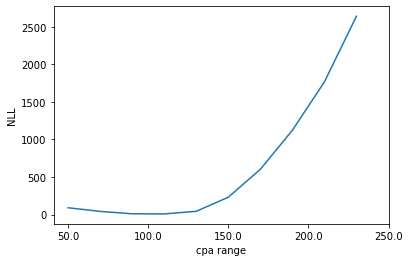

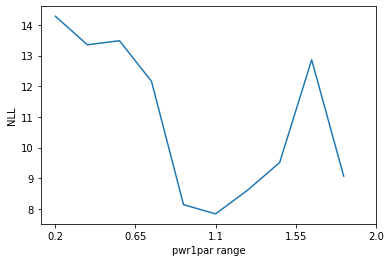

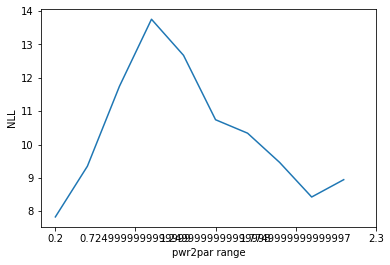

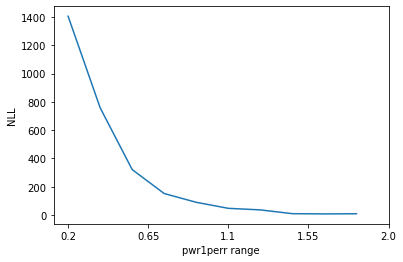

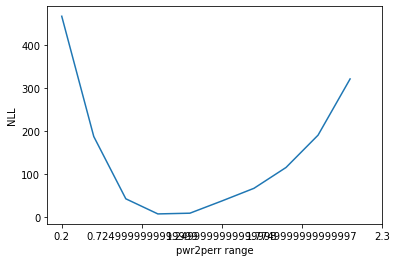

In [3]:
def calc_min_along_axis(X, axis):
    # Take min NLL along specified axis, with all other axes flattened.
    axes = np.arange(5)
    axes[axis] = 0
    axes[0] = axis
    temp = np.transpose(X, axes=axes)
    temp = temp.reshape((temp.shape[0], -1))
    rval = temp.min(axis=1) 
    return rval

PARAMETER_NAMES = ['cpa', 'pwr1par', 'pwr2par', 'pwr1perr', 'pwr2perr']
MIN = np.array([50., 0.2, 0.2, 0.2, 0.2]) 
MAX = np.array([250., 2., 2.3, 2., 2.3]) 
    
for i in range(5):
    nll = calc_min_along_axis(-logps, axis=i)
    plt.figure(i)
    plt.plot(np.arange(0,1,s), nll)
    plt.ylabel('NLL')
    plt.xlabel(f'{PARAMETER_NAMES[i]} range')
    plt.xticks(np.linspace(0,1,5), np.linspace(MIN[i], MAX[i], 5))